# Model of K and Cs kinetics in "soil-plant" system

In [3]:
import numpy as np
from scipy.optimize import basinhopping


def michael_menten(c_i, i_max, k_m, c_min=0):
  ''' Michaelis-Menten model for kation kinetics in soil solution - plant root system
   c_i -- concentration of K+ in mkM
   i_max -- I_m (maximum inflow) mkM cm^{-1} s^{-1} (possible options g^{-1}, cm^{-2}, m^{-2} etc.)
   c_min -- C_{min} minimum concentration mkM
   K_m -- (Michaeles constant) mkM
   return I_n dimension according to I_m
  '''
  i_n = (i_max * (c_i - c_min))/(k_m + (c_i - c_min))
  return i_n

def michael_menten_inhibitory(c_i, i_max, k_m, c_min=0, c_inh=0, k_inh=0):
  ''' Michaelis-Menten model for kation kinetics in soil solution - plant root system
      with inhibitory effect of one ion on another K - Cs, NH_4 - Cs
   c_i -- concentration of ion in mkM
   i_max -- I_m (maximum inflow) M cm^{-1} s^{-1} (possible options g^{-1}, cm^{-2}, m^{-2} etc.)
   c_min -- C_{min} minimum concentration mkM
   K_m -- (Michaeles constant) mkM
   c_inh - concentration of inhibitory ion (mkM) cite: shaw-1991-compet-effec
   k_inh - coefficient of inhibition (mkM)
   return I_n dimension according to I_m
  '''
  i_n = (i_max * (c_i - c_min))/(k_m * (c_inh/k_inh) + (c_i - c_min))
  return i_n


def cf_cesium(potassium, b1=1.64, b2=3.45):
  '''
     Calculate concentration ratio of radio-cesium from soil solution into plant
     depending on potassium concentration in the soil solution
     potassium - concentration of K^{+} in soil solution (mol l^{-1}) 
     b1, b2 -- species-specific coeffitients. for wheat (Tarsitano, 2011) by default
  '''
  neglog_cf = b1*np.log10(potassium) + b2
  return 10**(-1*neglog_cf)

def rhyzo_concentration(c_mean, i_n, d_l, theta, f, r0, l_v):
  ''' Calculate changes of cation concentration in rhyzosphere 
   based on it diffusion in soil and root uptake 
   Barraclough, 1986 (DOI: 10.1017/s0021859600061724)
   c_mean -- concentration of ion in mkM
   i_n -- root absorbtion of element mkM cm^{-1} s^{-1}
   d_l -- diffusion coefficient cm^{2} s^{-1}
   theta -- volumetric content of water l l^{-1}
   f -- 
   r0 -- average radius of root, cm
   l_v -- density of roots in soil cm cm^{-3}
   
  '''
  c_lo = (i_n / (4 * np.pi * d_l * theta * f)) * \
    (1 - 1/(1 - np.pi * r0**2 * l_v) * \
     np.log(1/(np.pi * r0**2 * l_v))) + c_mean
  return c_lo

def diff_rhyzo_concentration(k_lo):
  '''
  Function of cation concentration in rhyzosphere in form for optimization 
  '''
  i_k = michael_menten(k_lo[0], i_max, k_m) # mol cm-1 s-1
  diff = c_mean - k_lo[0] + 1e9*((i_k / (4 * 3.14 * d_l * theta * f)) * (1 - (1/(1-3.14*0.014**2*3) * np.log(1/(3.14*0.014**2*3))))) 
  return abs(diff)

def diff_rhyzo_concentration_cs(cs_lo):
  '''
  Function of cation concentration in rhyzosphere accounting inhibition
  by concurent cation in form for optimization 
  '''
  i_cs = michael_menten_inhibitory(cs_lo[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh) # mkmol cm-1 s-1
  diff = c_cs - cs_lo[0] + 1e3*((i_cs / (4 * 3.14 * d_lcs * theta * f)) * (1 - (1/(1-3.14*0.014**2*3) * np.log(1/(3.14*0.014**2*3)))))
  return abs(diff)

#---------------------------------------------------------#
r0 = 1.5e-2 # average diameter of roots
d_l = 1.98e-5 # diffision coeffitient for K+ in water
l_v = 3.0 # density of roots in soil (cm/cm^{3})
k_m = 299 # Michaelis constant for potassium uptake by root
c_min = 0 # Michaelis-Menten equation parameter for K+
i_max = 4.58e-13 # Michaelis-Menten equation parameter for K+ mol cm-1 s-1

c_mean = 150 # mkM concentration of K+ in soil solution in total soil
theta = 0.3 # relative volume water content in soil l l-1 
# soil properties for diffusion coefficient 
# according to Olesen, 2001 doi: 10.1097/00010694-200102000-00002
CF = 0.005 # relative weight content of clay (<2 mkm) in soil g g-1
SF = 0.05 # relative weight content of silt (2-20 mkm) in soil g g-1 2--20 мкм
ro = 1.3 # volume weight of soil t m-3
theta_th = 0.81*CF - 0.90*CF**2 -  0.07*SF - 0.6*ro + 0.22*ro**2 + 0.42 # threshold theta
f = 1.1 * (theta - theta_th) # impedance factor
if f < 0: f = 0

#cs kinetics
i_max_cs = 3e-7 # mkmol/ l Michaelis-Menten equation parameter for Cs+
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
# 1.53 mkmol Cs g-1 (root) h-1 = 3e-7 mkmol cm-1 s-1 (r0 = 1.5e-2); 1 Bq/l of Cs-137 = 2.24e−9 mkM (Robson and Pitman, 1983)
k_m_cs = 5.8 # mkmol Cs ; Michaelis constant for cesium uptake by root
k_inh = 3.1 # mkmol K ; inhibition coefficient K->Cs
d_lcs = 2.06e-5 # diffision coeffitient for Cs+ in water
nh4_inh = 11.2 # mkmol NH4; inhibition coefficient NH4->Cs

# parameters for optimization
k_lo = [1] # concentration of K, Cs in root zone (mkM); root influx of K and Cs (mol cm-2 s-1)
cs_lo = [1] # concentration of Cs in root zone (mkM); root influx of K and Cs (mol cm-2 s-1)
minimizer_kwargs = {'method': 'BFGS'}

ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
ret_k.x[0]

120.44122908678969

## Modelling behaviour of K<sup>+</sup> and Cs<sup>+</sup> in "soil-plant" system in dependence of soil properties, potassium concentration in soil solution and water content in soil.

In [10]:
import pandas as pd

c_mean = 50 # mkM
c_cs = 1 # mkM Cs+ (stable)
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
# 1.53 mkmol Cs g-1 (root) h-1 = 3e-7 mkmol cm-1 s-1 (r0 = 1.5e-2); 1 Bq/l of Cs-137 = 2.24e−9 mkM (Robson and Pitman, 1983)

minimizer_kwargs = {'method': 'BFGS'}
soil_gravi = {'name': ['sand','loam','silt','clay'], 'CF': [0.01, 0.02, 0.03, 0.08], 'SF': [0.05, 0.10, 0.20, 0.40], 'ro': [1.4, 1.3, 1.34, 1.4], 'theta_max': [0.125, 0.178, 0.296, 0.333]}
potassium = [50, 150, 250, 500, 750, 1000, 1500, 2500, 5000, 10000]
calculations = {'soil': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_mean': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}

for c_mean in potassium:
  for i in range(len(soil_gravi['name'])):
    theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
    for theta in np.linspace(0.02, soil_gravi['theta_max'][i], 25):
      k_lo = [1]
      cs_lo = [1]
      f = 1.1 * (theta - theta_th)
      if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
      if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
      calculations['soil'].append(soil_gravi['name'][i])
      calculations['theta'].append(theta)
      calculations['theta_rel'].append(theta / soil_gravi['theta_max'][i])
      calculations['k_mean'].append(c_mean)
      calculations['f'] = f
      ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
      c_k_inh = ret_k.x[0]
      calculations['k_lo'].append(ret_k.x[0])
      calculations['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
      ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
      cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
      calculations['cs_lo'].append(ret_cs.x[0])
      calculations['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
      calculations['cf_cs'].append(cf_cs)
      sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
      calculations['cs_plant'].append(sa_cs_plant)
      
data = pd.DataFrame(calculations)
data.head()

,soil,theta,theta_rel,f,k_mean,k_lo,cs_lo,cf_cs,cs_plant,i_k,i_cs
0,sand,0.028750,0.230,0.319836,50,0.624315,0.000078,5.315424e+06,41.615988,9.543159e-16,2.010687e-11
1,sand,0.033125,0.265,0.319836,50,0.955270,0.000184,2.646018e+06,48.772157,1.458597e-15,3.093591e-11
2,sand,0.037500,0.300,0.319836,50,1.344129,0.000367,1.511321e+06,55.513588,2.049686e-15,4.381200e-11
3,sand,0.041875,0.335,0.319836,50,1.788486,0.000655,9.460707e+05,61.986236,2.723265e-15,5.872946e-11
4,sand,0.046250,0.370,0.319836,50,2.285633,0.001079,6.327460e+05,68.275949,3.474510e-15,7.567933e-11


In [11]:
data.to_csv('model_result_k_cs_root_uptake_water.csv')

## Concentration of potassium in soil average solution is 50 mkM

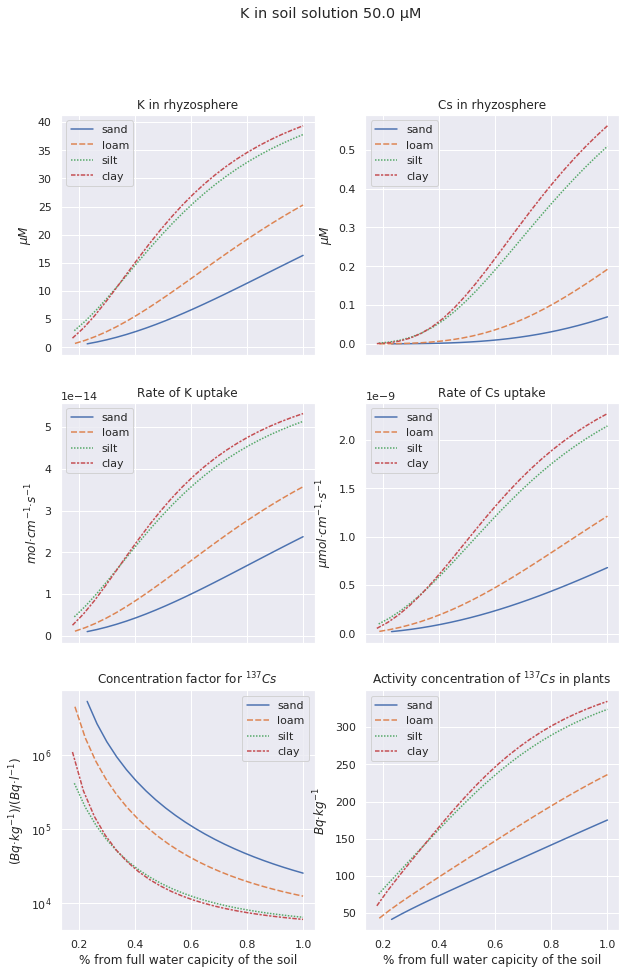

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() # Setting seaborn as default style even if use only matplotlib
#data = pd.read_csv('model_result_k_cs_root_uptake_water.csv')

def plot_kinetics(c_mean):
  ''' Plot results of modelling for given concentration of potassium in soil solution
  '''
  data_k = data.loc[data.k_mean == c_mean]
  fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharex=True)
  fig.suptitle(f'K in soil solution %.1f µM' % (c_mean))
  sns.lineplot(ax = axes[0,0], x='theta_rel', y='k_lo', hue='soil', style='soil', data=data_k)
  axes[0,0].set_title('K in rhyzosphere')
  axes[0,0].set_ylabel('$µM$')
  sns.lineplot(ax = axes[0,1], x='theta_rel', y='cs_lo', hue='soil', style='soil', data=data_k)
  axes[0,1].set_title('Cs in rhyzosphere')
  axes[0,1].set_ylabel('$µM$')
  sns.lineplot(ax = axes[1,0], x='theta_rel', y='i_k', hue='soil', style='soil', data=data_k)
  axes[1,0].set_title('Rate of K uptake')
  axes[1,0].set_ylabel('$mol·cm^{-1}·s^{-1}$')
  sns.lineplot(ax = axes[1,1], x='theta_rel', y='i_cs', hue='soil', style='soil', data=data_k)
  axes[1,1].set_title('Rate of Cs uptake')
  axes[1,1].set_ylabel('$µmol·cm^{-1}·s^{-1}$')
  sns.lineplot(ax = axes[2,0], x='theta_rel', y='cf_cs', hue='soil', style='soil', data=data_k)
  axes[2,0].set_title('Concentration factor for $^{137}Cs$')
  axes[2,0].set_yscale('log')
  axes[2,0].set_ylabel('$(Bq·kg^{-1})/(Bq·l^{-1})$')
  sns.lineplot(ax = axes[2,1], x='theta_rel', y='cs_plant', hue='soil', style='soil', data=data_k)
  axes[2,1].set_title('Activity concentration of $^{137}Cs$ in plants')
  axes[2,1].set_ylabel('$Bq·kg^{-1}$')
  axes[2,1].set_xlabel('% from full water capicity of the soil')
  axes[2,0].set_xlabel('% from full water capicity of the soil')
  for i in range(3):
    for j in range(2):
      handles, labels = axes[i,j].get_legend_handles_labels()
      axes[i,j].legend(handles=handles[1:], labels=labels[1:]) # title = 'New title'

plot_kinetics(50)

Результаты моделирования показывают, что при очень низкой концентрации K<sup>+</sup> в почвенном растворе (0,05 мМ·л<sup>-1</sup>) концентрация катионов калия и цезия в ризосфере возрастает по мере увеличения влажности почвы. При этом доступность данных катионов на глинистой и суглинистой почве существенно выше по сравнению с песчаной и супечаной. При содержании воды в почве 50% от полной влагоемкости на песчаной почве концентрация K<sup>+</sup> в ризосфере чрезвычайно низка низка -- составляет всего 10% от его средней концентрации в почвенном растворе, а на глинистой и суглинистой почве превышает 40% от средней концентрации.

Скорость корневого поглощения K<sup>+</sup> и Cs<sup>+</sup> при увеличении влажности также монотонно увеличивается вслед за ростом концентрации катионов в ризосфере. По мере повышения доступности K<sup>+</sup> в ризосфере падает почти на два порядка величины коэффициент концентрирования Cs<sup>+</sup> из почвенного раствора в надземные органы растений. При этом наблюдаются существенные (около одного порядка величины) различия между почвами различного механического состава. Коэффициент концентрирования снижается в направлении песчаная - супесчаная - глинистая, суглинистая почвы. Удельная активность <sup>137</sup>Cs в растении определяется изменением коэффициента концентрирования и содержания радиоизотопа в почвенном растворе. Падение коэффициента концентрирования по мере увеличения влажности почвы при очень низкой концентрации K<sup>+</sup> в почвенном растворе не может компенсировать рост концентрации <sup>137</sup>Cs<sup>+</sup> в ризосфере. В результате удельная активность радиоизотопа в надземных частях растения монотонно увеличивается по мере приближения влажности почвы к 100% от ПВ. При изменении влажности от 40 до 100% от ПВ удельная активность <sup>137</sup>Cs в растении увеличивается почти в два раза на всех модельных почвах. На глинистой и суглинистой почвы она существенно выше по сравнению с песчаной и супесчаной.

## Concentration of potassium in soil average solution is 150 mkM

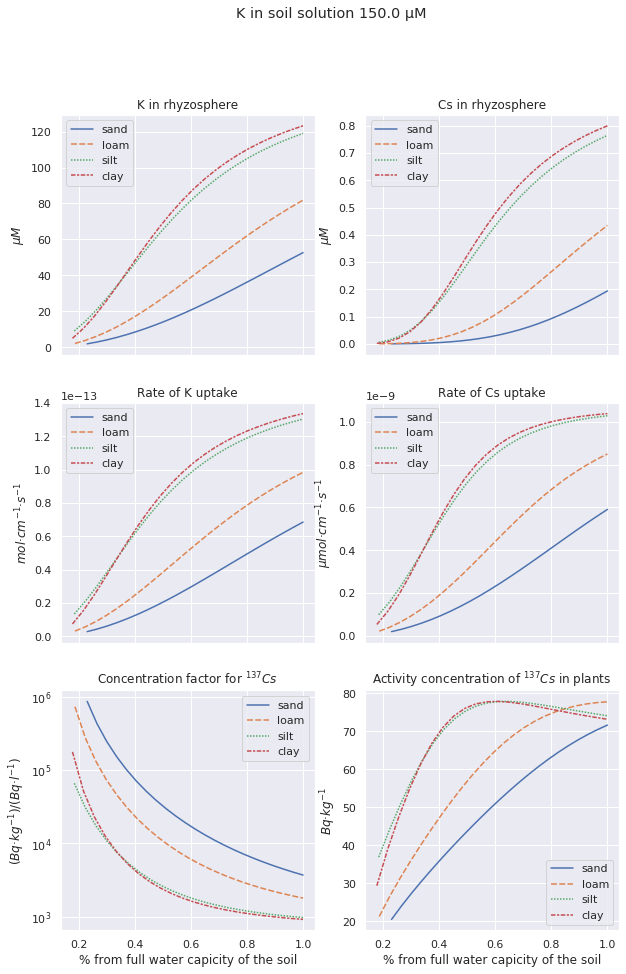

In [13]:
plot_kinetics(150)

Изменение концентрации K^{+} и Cs{+} в ризосфере в зависимости от влажности почвы при увеличенном до 0,15 мМ·л^{-1} содержании калия в почвенном растворе имеет сходный характер с предыдущим вариантом. Можно лишь заметить, что по мере приближения к полной влагоемкости происходи более сильный загиб кривых книзу для суглинистой и глинистых почв. При содержании влаги 50% от ПВ концентрация K^{+} в ризосфере на песчаной почве составляет около 15% от средней концентрации в почве, а на глинистой и суглинистой -- около 65%.

Скорость корневого поглощения K^{+} здесь приблизительно в три раза выше, чем в предыдущем варианте практически на всем диапазоне содержания воды в почве. Скорость поглощения Cs^{+} почти в два раза ниже, а на глинистой и суглинистой почвах она начинает выходить на плато по мере приближения к состоянию полного насыщения почвы влагой. Повышение концентрации калия в почвенном растворе сопровождает падением потока {137}Cs через единицу длины корня и уменьшением коэффициента концентрирования.

На песчаной и супесчаной почвах накопление ^{137}Cs в растениях увеличивается по мере насыщения почвы водой, как и в варианте с более низкой концентрацией K^{+} в почвенном растворе, но здесь оно в два--три раза ниже. На глинистой и суглинистой почвах наблюдается несколько иная картина. Увеличение удельной активности ^{137}Cs в надземных органах растения происходит при увеличении влажности до 60% от ПВ. При дальнейшем увеличении влажности почвы рост концентрации цезия в ризосфере уже не может компенсировать падение коэффициента концентрирования и происходит небольшое снижение удельной активности.

## Concentration of potassium in soil average solution is 250 mkM

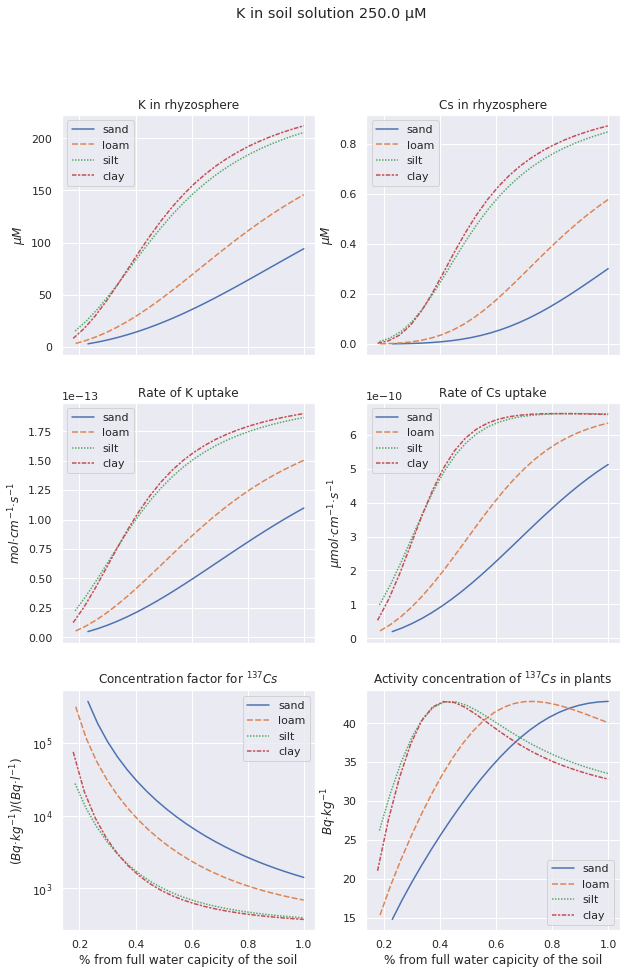

In [14]:
plot_kinetics(250)

Рост содержания K^{+} в почвенном растворе до 0,25 мМ·л^{-1} усиливает выявленные в предыдущем варианте тенденции. Скорость корневого поглощения цезия на глинистой и суглинистых почвах выходит на отчетливое плато при достижении влажности 75% от ПВ, а удельная активность максимальна при содержании воды 40% от ПВ, снижаясь на 15% при содержании воды 90% от ПВ. Проявляется максимум в накоплении ^{137}Cs надземными частями растений на супесчаной почве при влажности 70% от ПВ.


## Concentration of potassium in soil average solution is 500 mkM

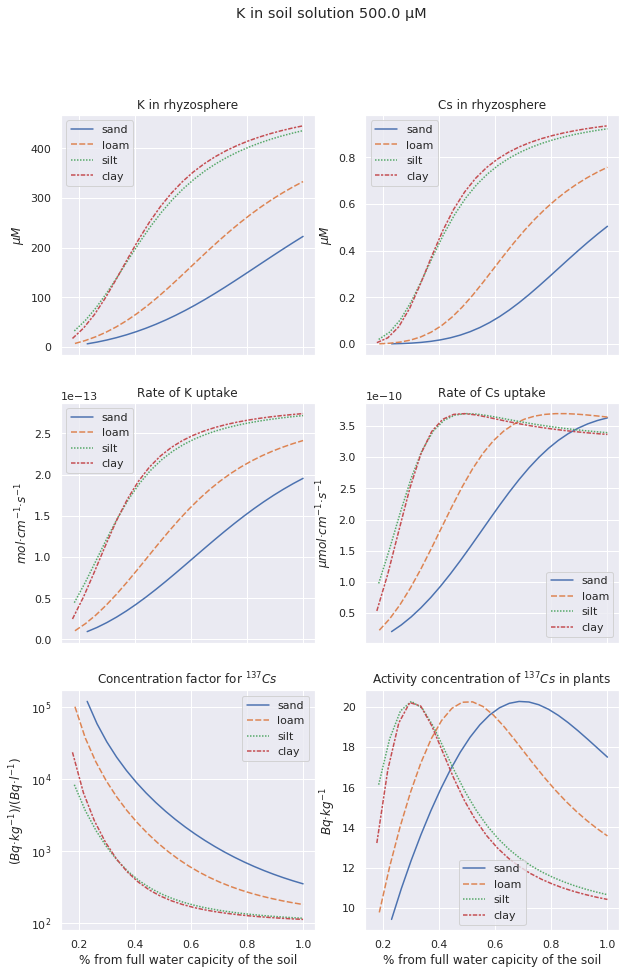

In [15]:
plot_kinetics(500)

Закономерность увеличения концентрации K^{+} и Cs^{+} в ризосфере с ростом содержания воды в почве сохраняется и при достижении средней концентрации калия в почвенном растворе 0,5 мМ·л^{-1}. Также сохраняется закономерность более низкого содержания калия и цезия в ризосфере на песчаных и супесчаных почвах по сравнению с глинистыми и суглинистыми. Увеличение концентрации K^{+} в почвенном растворе всего объема почвы и в ризосфере закономерно приводит к росту скорости корневого поглощения данного катиона и падению скорости корневого поглощения Cs^{+}. Причем на всех почвах кроме песчаной скорость поглощения Cs^{+} в расчете на единицу длины корня достигает максимума при определенной влажности почвы, а затем начинает снижаться.

Коэффициент концентрирования ^{137}Cs из почвенного раствора в надземные органы растения при аналогичном содержании калия в почвенном растворе 0,5 мМ·л^{-1} и влажности 80% от ПВ составляет на глинистой и суглинистой почве около 100 л·кг^{-1}, на супесчаной -- около 250, а на песчаной -- около 900. Это указывает на то, что механический состав почвы оказывает существенное влияние на поведение ^{137}Cs в системе «почва-растени» даже без учета его связи с содержанием доступных форм калия. 

При содержании K^{+} в почвенном растворе 0,5 мМ·л^{-1} на всех моделируемых почвах наблюдается заметное падение удельной активности ^{137}Cs в надземных частях растений после превышения влажности почвы определенного уровня. Если рассматривать 75% от ПВ в качестве оптимального уровня влажности почвы, то на песчаной почве на него приходится максимум накопления радионуклида, на супесчаной накопление составляет приблизительно 94% от максимального, на глинистой и суглинистой -- около 60%. 

## Concentration of potassium in soil average solution is 750 mkM

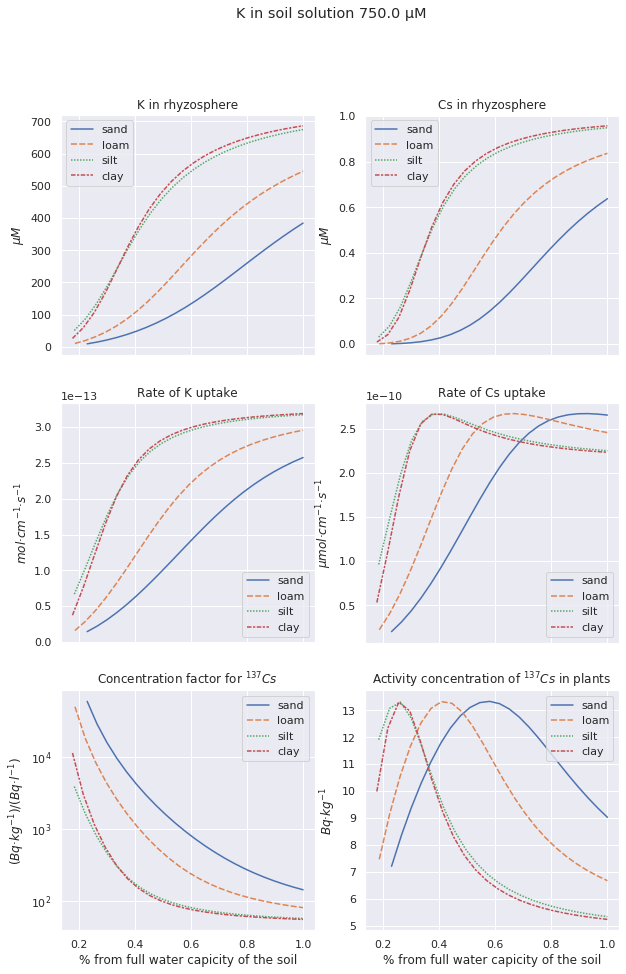

In [16]:
plot_kinetics(750)

При средней концентрации K^{+} в почвенном растворе 0,75 мМ·л^{-1} описанные в предыдущих вариантах зависимости поведения ^{137}Cs в системе «почва-растение» при изменении влажности почвы становятся более отчетливыми. На глинистых и суглинистых почвах максимальная удельная активность  ^{137}Cs в надземных органах модельного растения достигается при уровне влажности соответствующему острой засухе; на супесчаной почве -- при 45% от ПВ, на песчаных -- при 55% от ПВ.


## Concentration of potassium in soil average solution is 1000 mkM

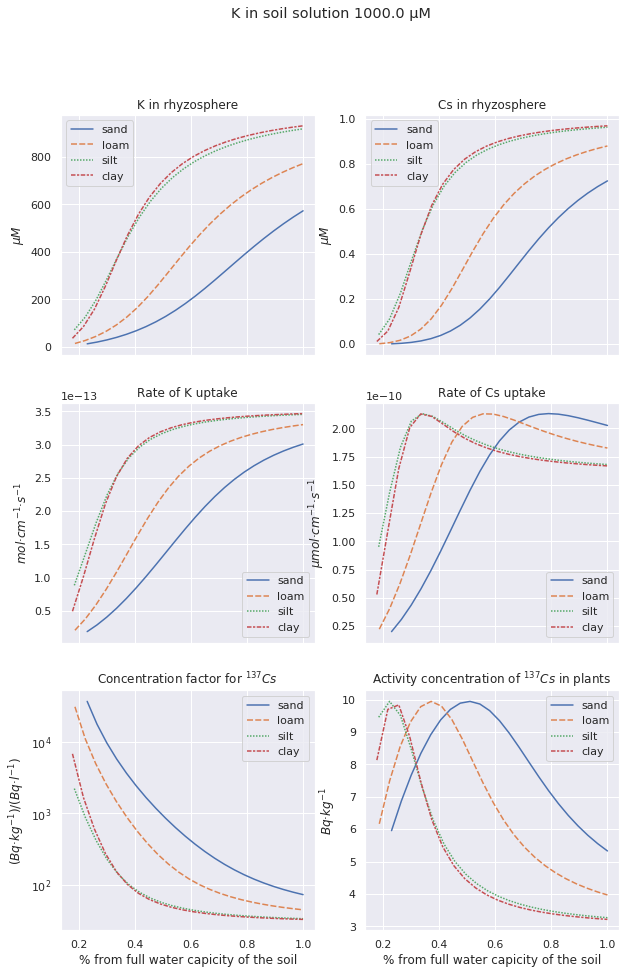

In [17]:
plot_kinetics(1000)

При оптимальном содержании калия в почвенном растворе (1 мМ·л^{-1}) содержание K^{+} в ризосфере при влажности почвы 75% от ПВ составляет на глинистых и суглинистых почвах около 85% от его содержания в общем объеме почве, на супесчаной почве -- 60%, на песчаной -- 38%. При влажности почвы 35% от ПВ аналогичные показатели оставляют 50%, 14% и 9% соответственно. В то же время концентрация Cs^{+} в ризосфере при влажности 75% от ПВ на глинистой и суглинистой почве приближается к средней в объеме почвы, а на супесчаной и песчаной почвах составляет более 50%. Снижение влажности почвы понижает концентрацию Cs^{+} в ризосфере, причем на глинистых и суглинистых почвах это понижение происходит более резко.

Интенсивность корневого поглощения K^{+} увеличивается по мере роста влажности почвы, при влажности почвы 35% от ПВ она составляет 0,7--2,7·10^{-13} моль·см^{-1}·с^{-1} (выше на глинистой и суглинистой почве), а при влажности 75% от ПВ она составляет 2,5--3,5·10^{-13} моль·см^{-1}·с^{-1}. Интенсивность корневого поглощения K^{+} на глинистой и суглинистой почве практически выходит на плато и слабо изменяется при достижении влажности почвы 60% от ПВ. На песчаной и супесчаной почвах четкого выхода на плато не наблюдается. Интенсивность корневого поглщения Cs^{+} достигает максимума при определенной влажности почвы, в зависимости от механического состава. При дальнейшем увеличении влажности происходит незначительное снижение данного показателя. Для всех моделируемых почв скорость корневого поглощения Cs^{+} при влажности почвы выше 25% от ПВ преимущественно находится в пределах 1,7--2,0 µмоль·см^{-1}·с^{-1}.

Результаты моделирования показывают, что при оптимальном содержании K^{+} в почвенном растворе удельная активность ^{137}Cs в надземных частях растения имеет максимальное значение около 10 Бк·кг^{-1} при влажности почвы (в % от ПВ) на глинистой и суглинистой почвах -- 25%, на супесчаной -- 35%, на песчаной -- 50%. При оптимальном значении влажности почвы (75% от ПВ) удельная активность ^{137}Cs в надземных частях растения на глинистой и суглинистой почве составляет 35% от максимального значения, на супесчаной -- 50%, на песчаной -- 75%.


## Concentration of potassium in soil average solution is 1500 and 2500 mkM

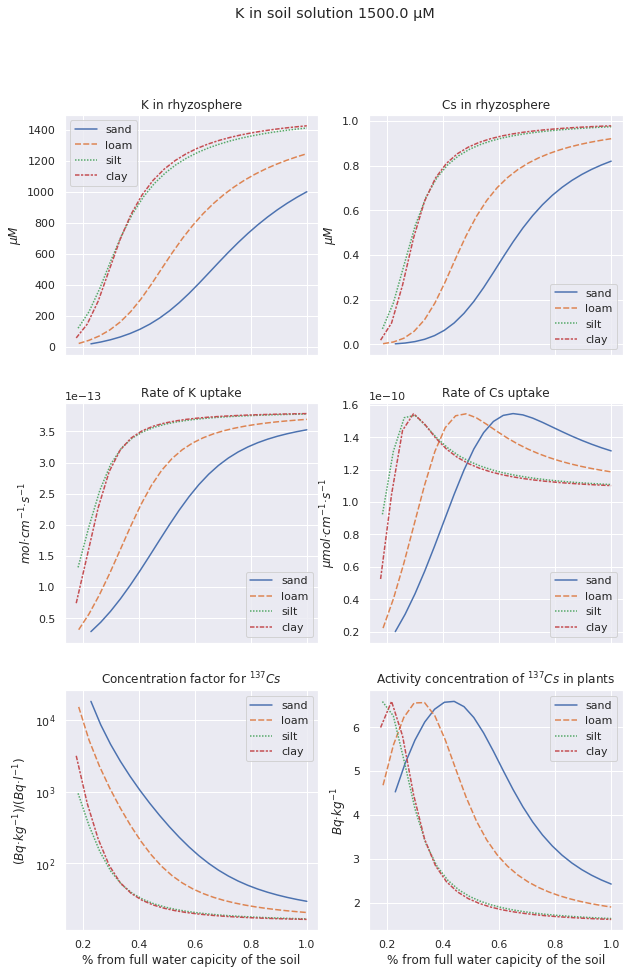

In [18]:
plot_kinetics(1500)

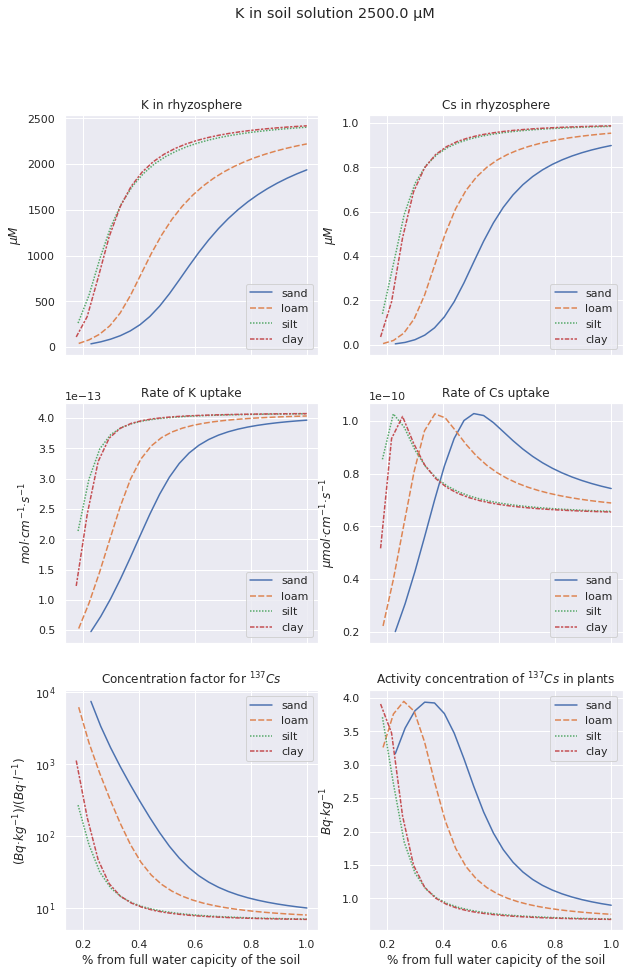

In [19]:
plot_kinetics(2500)

При повышении концентрации калия в почвенном растворе до 1,5 и 2,5 мМ·л^{-1} усиливаются описанные выше тренды влияния влажности почвы на содержания K^{+} и Cs^{+} в ризосфере, интенсивности корневого поглощения данных катионов и накоплении ^{137}Cs в надземных частях растений. При концентрации калия в почвенном растворе 2,5 мМ·л^{-1} интенсивность корневого поглощения данного катиона практически находится на плато при влажности почвы выше 75% от ПВ на всех вариантах механического состава, при этом на суглинистой и глинистой почвах можно говорить о выходе на плато данного показателя уже при влажности 40% от ПВ.

Коэффициент концентрирования ^{137}Cs из почвенного раствора в надземные органы растений при влажности почвы 75% от ПВ близок для всех вариантов механического состава почвы и составляет 9--11. При засухе (35% от ПВ) на песчаной почве он достигает величины порядка 10^{3}, на на супесчаной -- 10^{2}. Удельная активность ^{137}Cs в растениях на всех вариантах механического состава почвы снижается уже при влажности выше 40% от ПВ.

## Concentration of potassium in soil average solution is 5 and 10 mM

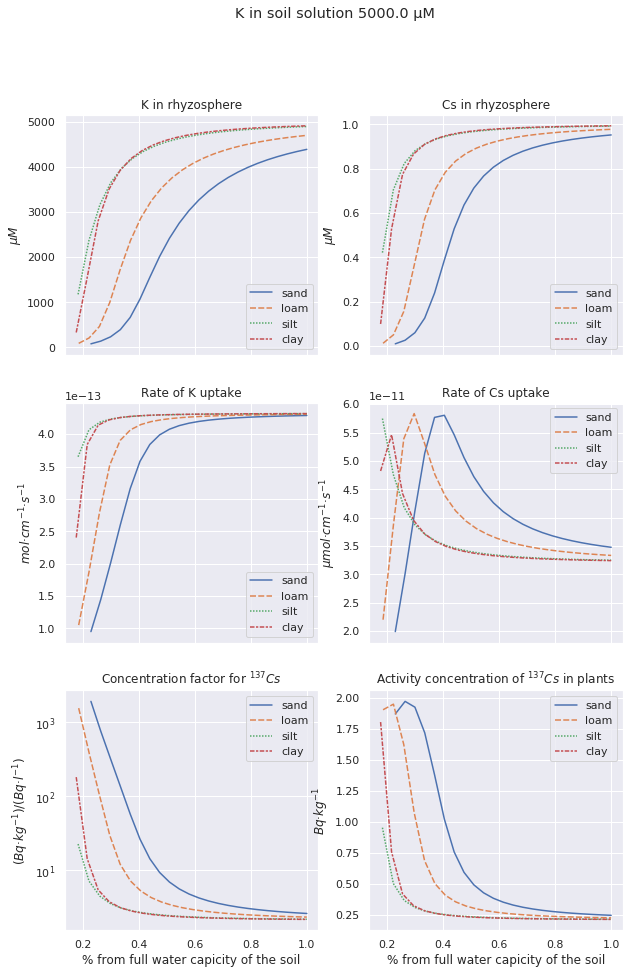

In [20]:
plot_kinetics(5000)

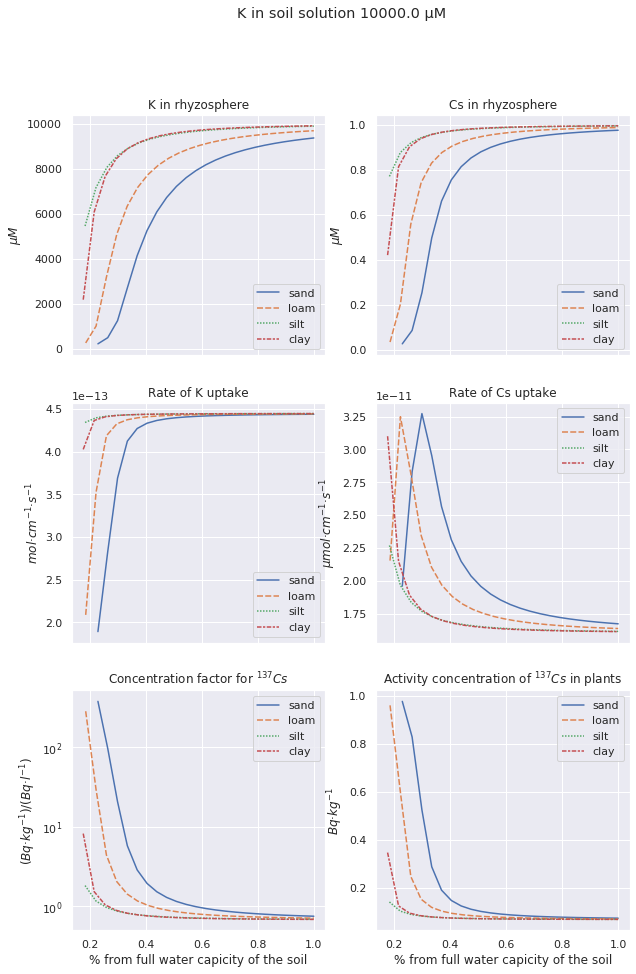

In [21]:
plot_kinetics(10000)

На фоне высокого содержания калия в почвенном растворе (5 и 10 мМ·л^{-1}) такие показатели как содержание K^{+} и Cs^{+} в ризосфере, интенсивность корневого поглощения данных катионов, коэффициент концентрирования и удельная активность в растениях ^{137}Cs слабо зависят от влажности в условиях близки к оптимальной и избыточной влагообеспеченности. На глинистой и суглинистой почвах слабозаметно влияние влажности на данные показатели и в диапазоне засушливых условий. На песчаной почве в условиях засухи концентрация K^{+} и Cs^{+} в ризосфере ниже в 3--6 раз по сравнению с оптимальными условиями, интенсивность поглощения Cs^{+} выше почти в два раза, коэффициент концентрирования -- выше более чем на порядок величины. Совокупность данных изменений, взыванных недостаточной влагообеспеченностью приводит к тому, что на фоне высокой обеспеченности калием удельная активность ^{137}Cs в растении при засухе может быть почти в пять раз выше по сравнению с условиями оптимальной влагообеспеченности. Супесчаные почвы в данном отношении занимают промежуточное положение между песчаными и глинистыми с суглинистыми.

Text(0.5, 0, '% from full water capicity of soil')

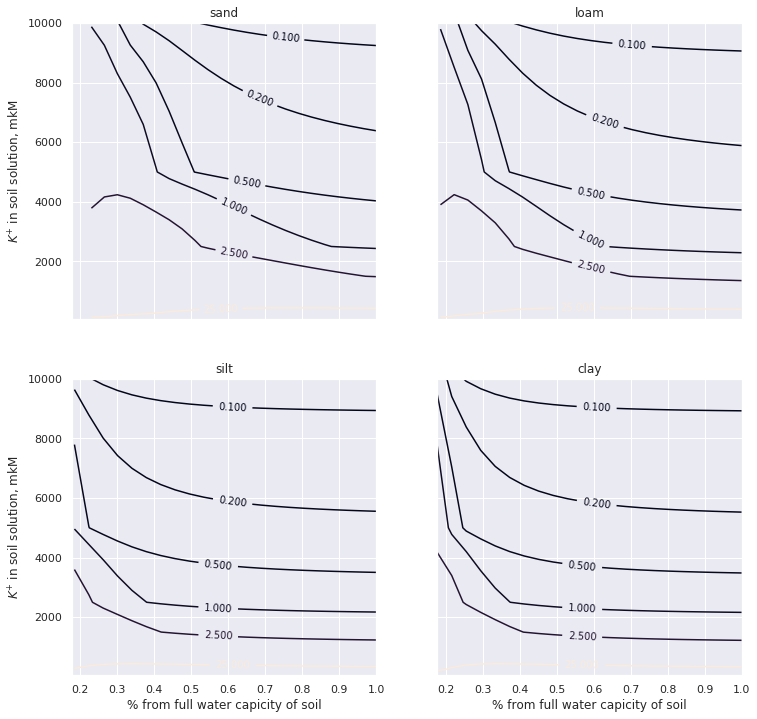

In [23]:
import numpy as np
from matplotlib import cm as cm
fig, ax = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)
soils = data.soil.unique()
for n, s in enumerate(soils):
  i = n % 2
  j = n // 2
  XX, YY = np.meshgrid(data[data['soil']==s].k_mean.unique(), data[data['soil']==s].theta_rel.unique())
  ZZ = [[data[(data['soil']==s) & (data['theta_rel'] == w) & (data['k_mean'] == k)]['cs_plant'].values[0] for k in data[data['soil']==s].k_mean.unique()] for w in data[data['soil']==s].theta_rel.unique()]
  levels = sorted([1, 0.5, 0.1,  2.5, 0.2, 25])
  cs = ax[j,i].contour(YY, XX, ZZ, levels)
  ax[j,i].clabel(cs, inline=True, fontsize=10)
  ax[j,i].set_title(s)
ax[0,0].set_ylabel('$K^{+}$ in soil solution, mkM')
ax[1,0].set_ylabel('$K^{+}$ in soil solution, mkM')
ax[1,0].set_xlabel('% from full water capicity of soil')
ax[1,1].set_xlabel('% from full water capicity of soil')

Таким образом, результаты моделирования указывают на сильное совместное влияние содржания воды в почве и калия в почвенном растворе на показатели корневого поступления ^{137}Cs и его накопления в надземных органах растения. Рисунок позволяет глубже проанализировать выявленные закономерности. Влияние влажности на накопление ^{137}Cs в надземных органах растения усиливается с увеличением содержания K^{+} в почвенном растворе. По мере снижения содержания влаги в почве усиливается влияние данного фактора на накопление  ^{137}Cs растениями. На глинистых и суглинистых почвах повышение влажности более 50% от ПВ при всех вариантах содержания K^{+} в почвенном растворе практически не изменяет уровень накопления ^{137}Cs в надземных органах растения. На супесчаной почве это можно сказать лишь содержании K^{+} в почвенном растворе выше 1 мМ·л^{-1}. На песчаной почве влияние влияние влажности почвы на показатель накопления ^{137}Cs растением сохраняется в наиболее широком диапазоне концентрации K^{+} в почвенном растворе и влажности почвы.


# Sensitivity of the model to soil texture and density, Michaelis-Menten equation parameters, Cs concentration in soil solution, root properties

Кроме влажности почвы, ее механического состава и содержания K^{+} в почвенном растворе на результаты моделирования может оказать влияние ряд других параметров, использованных в модели. В числе этих параметров -- показатели уравнения Михаэлиса-Меэнтен для кинетики корневого потребления K^{+} и Cs^{+}, концентрация стабильного изотопа цезия в почве, структура корневой системы, описываемое средней длиной сосущих корней на единицу объема и их диаметром. Анализ влияния данных параметров проведен для супесчаной почвы и влажности почвы 35%, 70% и 85% от ПВ, что соответствует засушливому, нормальному и переувлажненному режиму. Средняя концентрация K^{+} в почвенном растворе принята равной 0,75 мМ·л^{-1}.

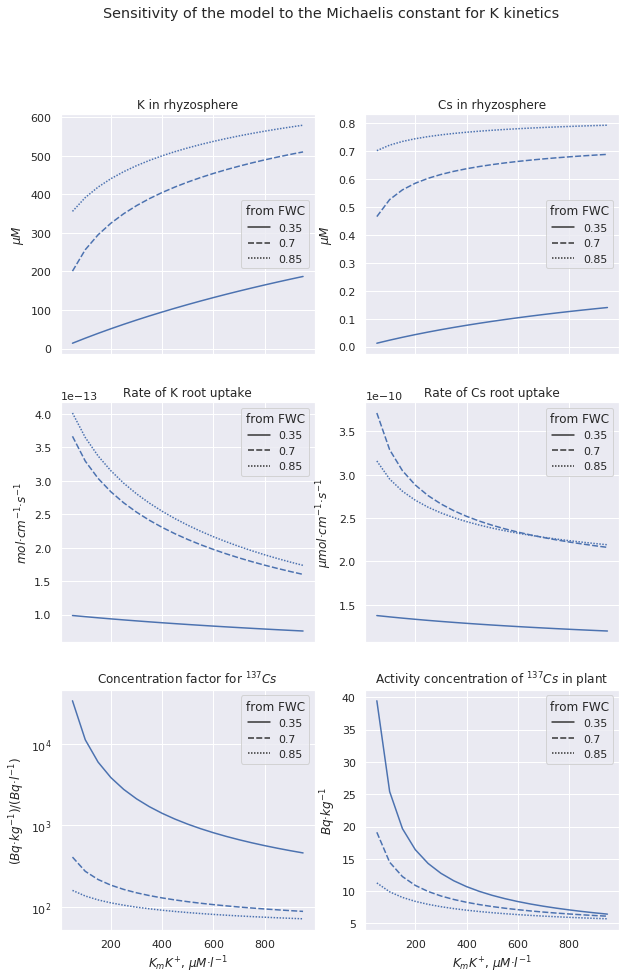

In [37]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_ms = range(50, 1000, 50) #299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
# 1.53 mkmol Cs g-1 (root) h-1 = 3e-7 mkmol cm-1 s-1 (r0 = 1.5e-2); 1 Bq/l of Cs-137 = 2.24e−9 mkM (Robson and Pitman, 1983)
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85] #[soil_gravi['theta_max'][1]*0.35, soil_gravi['theta_max'][1]*0.7, soil_gravi['theta_max'][1]*0.85]

calculations2 = {'theta': [], 'theta_rel': [], 'f': [], 'k_m': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for k_m in k_ms:
    k_lo = [1]
    cs_lo = [1]
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['k_m'].append(k_m)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
    #print('theta = %.2f, K_lo = %.3e, Cs_lo = %.3e, In(K) = %.3e, In(Cs) = %.3e, CF = %.4f, Cs_SA = %.4f Bq/kg' % (theta, ret_k.x[0], ret_cs.x[0], michael_menten(ret_k.x[0], i_max_cs, k_m_cs), michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh), cf_cs, sa_cs_plant) ) #ret_cs.x[1]))
data_k = pd.DataFrame(calculations2)

def make_graph_sensitivity(impact_variable, 
                           impaсt_variable_name,
                           title,
                           group_variable='theta_rel'):
  fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharex=True)
  sns.lineplot(ax = axes[0,0], x=impact_variable, y='k_lo', style=group_variable, data=data_k)
  axes[0,0].set_title('K in rhyzosphere')
  axes[0,0].set_ylabel('$µM$')
  sns.lineplot(ax = axes[0,1], x=impact_variable, y='cs_lo', style=group_variable, data=data_k)
  axes[0,1].set_title('Cs in rhyzosphere')
  axes[0,1].set_ylabel('$µM$')
  sns.lineplot(ax = axes[1,0], x=impact_variable, y='i_k', style=group_variable, data=data_k)
  axes[1,0].set_title('Rate of K root uptake')
  axes[1,0].set_ylabel('$mol·cm^{-1}·s^{-1}$')
  sns.lineplot(ax = axes[1,1], x=impact_variable, y='i_cs', style=group_variable, data=data_k)
  axes[1,1].set_title('Rate of Cs root uptake')
  axes[1,1].set_ylabel('$µmol·cm^{-1}·s^{-1}$')
  sns.lineplot(ax = axes[2,0], x=impact_variable, y='cf_cs', style=group_variable, data=data_k)
  axes[2,0].set_title('Concentration factor for $^{137}Cs$')
  axes[2,0].set_yscale('log')
  axes[2,0].set_ylabel('$(Bq·kg^{-1})/(Bq·l^{-1})$')
  sns.lineplot(ax = axes[2,1], x=impact_variable, y='cs_plant', style=group_variable, data=data_k)
  axes[2,1].set_title('Activity concentration of $^{137}Cs$ in plant')
  axes[2,1].set_ylabel('$Bq·kg^{-1}$')
  axes[2,1].set_xlabel(impaсt_variable_name)
  axes[2,0].set_xlabel(impaсt_variable_name)
  for i in range(3):
    for j in range(2):
      handles, labels = axes[i,j].get_legend_handles_labels()
      axes[i,j].legend(handles=handles[1:], labels=labels[1:], title = 'from FWC')
  fig.suptitle(title)

make_graph_sensitivity('k_m', '$K_{m} K^{+}$, $µM·l^{-1}$', 
                       'Sensitivity of the model to the Michaelis constant for K kinetics')

При моделировании использована константа Михаэлиса (K_{m}) для кинетики корневого поглощения K^{+} равная 299 µM·л^{-1}. На графиках представлен анализ зависимости показателей модели от K_{m}. Увеличение данного параметра приводит к росту содержания K^{+} и Cs^{+} в ризосфере. При влажности почвы 70% от ПВ на небольших значениях K_{m} влияние данного показателя на концентрацию катионов калия в ризосфере существенно. Концентрация Cs^{+} в ризосфере при этом изменяется в пределах 10%. Однако вблизи используемого значения зависимость концентрации катионов в ризосфере от K_{m} близка к линейной. Соотношение между изменением K_{m} и изменением концентрации K^{+} и Cs^{+} в ризосфере составляет приблизительно 5 : 1. 

Интенсивность коневого поглощения K^{+}, Cs^{+}, коэффициент концентрирования и удельная активность ^{137}Cs в растениях экспоненциально уменьшаются при увеличении K_{m} K^{+}.

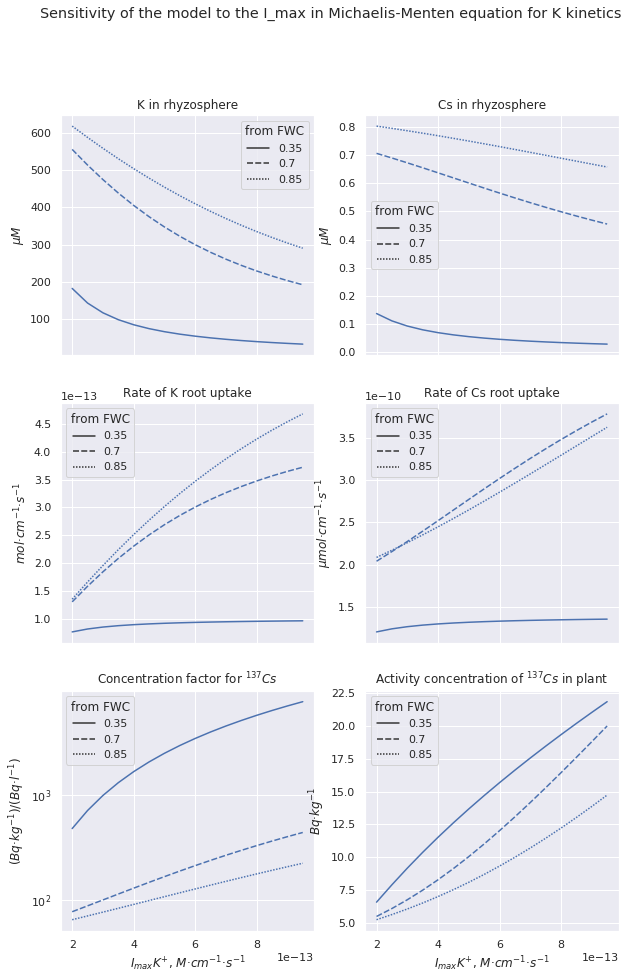

In [36]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_m = 299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
# 1.53 mkmol Cs g-1 (root) h-1 = 3e-7 mkmol cm-1 s-1 (r0 = 1.5e-2); 1 Bq/l of Cs-137 = 2.24e−9 mkM (Robson and Pitman, 1983)
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85] #[soil_gravi['theta_max'][1]*0.35, soil_gravi['theta_max'][1]*0.7, soil_gravi['theta_max'][1]*0.85]
#soil_gravi = {'name': ['песчаная','супесчаная','суглинистая','глинистая'], 'CF': [0.01, 0.02, 0.03, 0.08], 'SF': [0.05, 0.10, 0.20, 0.40], 'ro': [1.4, 1.3, 1.34, 1.4], 'theta_max': [0.125, 0.178, 0.296, 0.333]}

calculations2 = {'i_max': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for i_max in range(4,20):
    i_max = 1e-13*i_max/2
    k_lo = [1]
    cs_lo = [1]
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['i_max'].append(i_max)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
    #print('theta = %.2f, K_lo = %.3e, Cs_lo = %.3e, In(K) = %.3e, In(Cs) = %.3e, CF = %.4f, Cs_SA = %.4f Bq/kg' % (theta, ret_k.x[0], ret_cs.x[0], michael_menten(ret_k.x[0], i_max_cs, k_m_cs), michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh), cf_cs, sa_cs_plant) ) #ret_cs.x[1]))
data_k = pd.DataFrame(calculations2)

impact_variable='i_max'
impaсt_variable_name = '$I_{max} K^{+}$, $M·cm^{-1}·s^{-1}$'

make_graph_sensitivity(impact_variable, impaсt_variable_name, 
                       'Sensitivity of the model to the I_max in Michaelis-Menten equation for K kinetics')

Концентрации K^{+} и Cs^{+} снижаются с увеличением максимальной интенсивности корневого поглощения K^{+} в уравнении Михаэлиса-Ментен. В диапазоне используемого в моделировании значения (4,58·10^{-13} M·cm^{-1}·c^{-1}) данная зависимость близка к линейной. Остальные показатели модели имеют прямую связь с I_{max} K^{+}. Заметное падение концентации K^{+} в ризосфере при увеличении I_{max} приводит к сильному росту коэффициента концентрирования и удельной активности ^{137}Cs в растении.


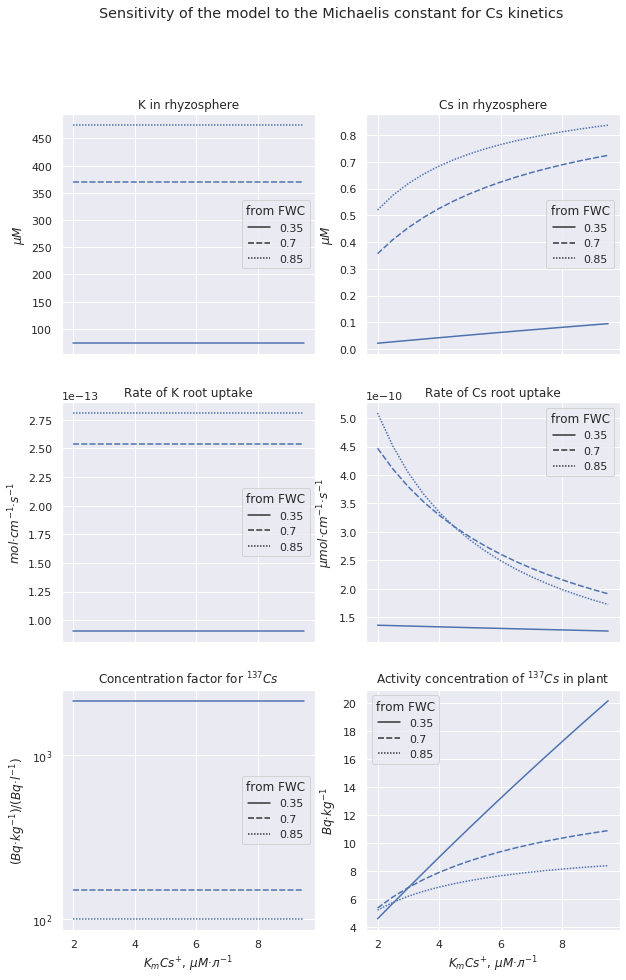

In [28]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_m = 299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
# 1.53 mkmol Cs g-1 (root) h-1 = 3e-7 mkmol cm-1 s-1 (r0 = 1.5e-2); 1 Bq/l of Cs-137 = 2.24e−9 mkM (Robson and Pitman, 1983)
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85] #[soil_gravi['theta_max'][1]*0.35, soil_gravi['theta_max'][1]*0.7, soil_gravi['theta_max'][1]*0.85]
#soil_gravi = {'name': ['песчаная','супесчаная','суглинистая','глинистая'], 'CF': [0.01, 0.02, 0.03, 0.08], 'SF': [0.05, 0.10, 0.20, 0.40], 'ro': [1.4, 1.3, 1.34, 1.4], 'theta_max': [0.125, 0.178, 0.296, 0.333]}

calculations2 = {'k_m_cs': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for k_m_cs in range(4,20):
    k_m_cs = k_m_cs/2
    k_lo = [1]
    cs_lo = [1]
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['k_m_cs'].append(k_m_cs)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
data_k = pd.DataFrame(calculations2)

impact_variable='k_m_cs'
group_variable='theta_rel'
impaсt_variable_name = '$K_{m} Cs^{+}$, $µM·л^{-1}$'
make_graph_sensitivity(impact_variable, impaсt_variable_name, 
                       'Sensitivity of the model to the Michaelis constant for Cs kinetics')

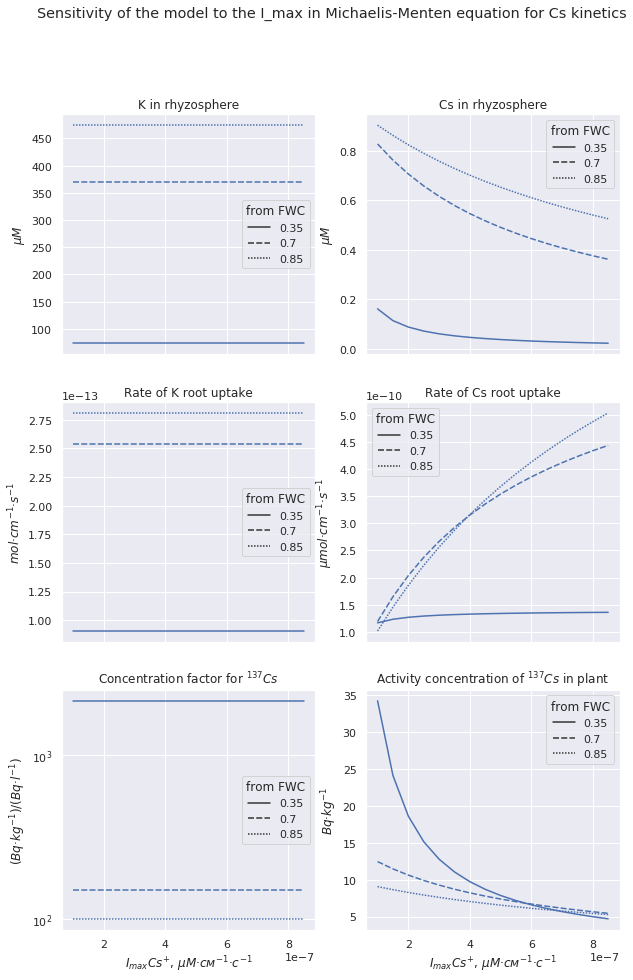

In [29]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_m = 299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85]
calculations2 = {'i_max_cs': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for i_max_cs in range(2,18):
    i_max_cs = 1e-7*i_max_cs/2
    k_lo = [1]
    cs_lo = [1]
    calculations2['i_max_cs'].append(i_max_cs)
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
data_k = pd.DataFrame(calculations2)

impact_variable='i_max_cs'
group_variable='theta_rel'
impaсt_variable_name = '$I_{max} Cs^{+}$, $µM·см^{-1}·с^{-1}$'
make_graph_sensitivity(impact_variable, impaсt_variable_name, 
                       'Sensitivity of the model to the I_max in Michaelis-Menten equation for Cs kinetics')

Показатели, связанные с корневым поглощением калия и коэффициент концентрирования ^{137}Cs из почвенного раствора в растение не зависят от параметров кинетики корневого поглощения цезия. Увеличение K_{m} Cs^{+} повышает содержание данного катиона в ризосфере. Причем, если в условиях засухи эта зависимость выражена не сильно и имеет линейный характер, то при оптимальном и избыточном увлажнении зависимость более сильная и приобретает логарифмический характер. Интенсивность корневого поглощения Cs^{+} падает с увеличением константы Михаэлиса для кинетики корневого потребления данного элемента при оптимальной и сверхоптимальной влажности почвы. При недостаточном увлажнении данный параметр практически не влияет на инетнсивность корневого потребления цезия. Существенное уменьшение концентрации K^{+} в ризосфере при влажности почвы 35% от ПВ приводит к тому, что удельная активность ^{137}Cs в надземных органах имеет сильную линейную зависимость от K_{m} Cs^{+}. При более высокой влажности почвы эта зависимость слабее и по форме повторяет зависимость концентрации Cs^{+} в ризосфере от K_{m} Cs^{+}.

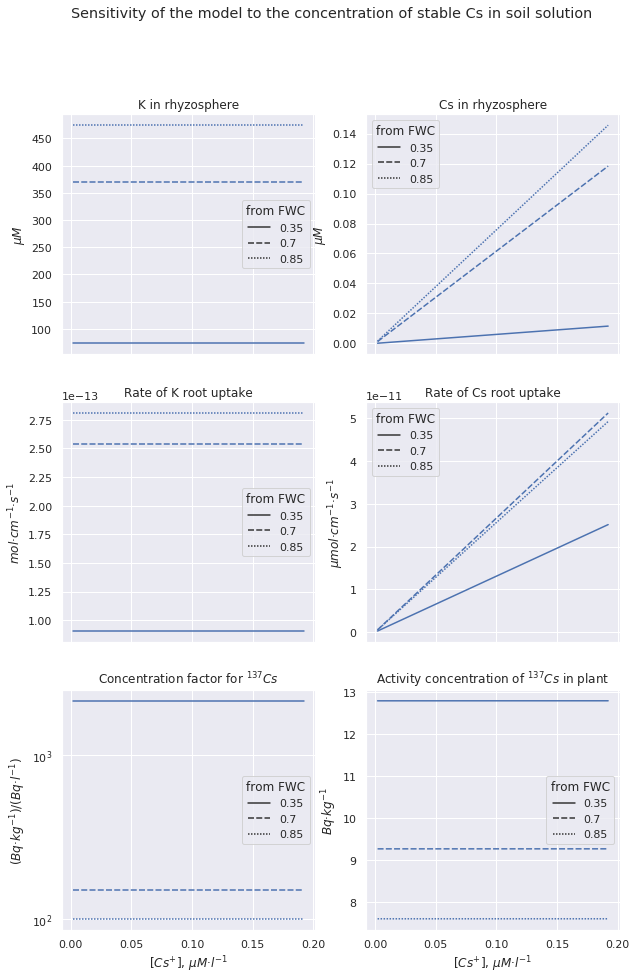

In [30]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_m = 299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85]
calculations2 = {'c_cs': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for c_cs in range(2,200,10):
    c_cs = c_cs/1000
    sa_cs_solution = cs_solution / c_cs
    k_lo = [1]
    cs_lo = [1]
    calculations2['c_cs'].append(c_cs)
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
data_k = pd.DataFrame(calculations2)

impact_variable='c_cs'
impaсt_variable_name = '$[Cs^{+}]$, $µM·l^{-1}$'
make_graph_sensitivity(impact_variable, impaсt_variable_name, 
                       'Sensitivity of the model to the concentration of stable Cs in soil solution')

Концентрация стабильного изотопа цезия в почвенном растворе имеет прямолинейную связь с его содержанием в ризосфере. Интенсивность корневого поглощения Cs^{+} также имеет практически линейную связь с концентрацией данного катиона в почвенном растворе, это обусловлено тем, что концентрация Cs^{+} в ризосфере остается существенно ниже константы Михаэлиса. Однако при этом концентрация ^{137}Cs в почвенном растворе остается неизменной по условию моделирования, интенсивность поглощения RCs также не изменяется (снижается его вклад в смеси поглощаемых изотопов пропорционально росту интенсивности их корневого поглощения). Данные результаты свидетельствуют об отсутствии необходимости учитывать концентрацию стабильного изотопа цезия для прогноза и расчета коэффициента накопления RCs.


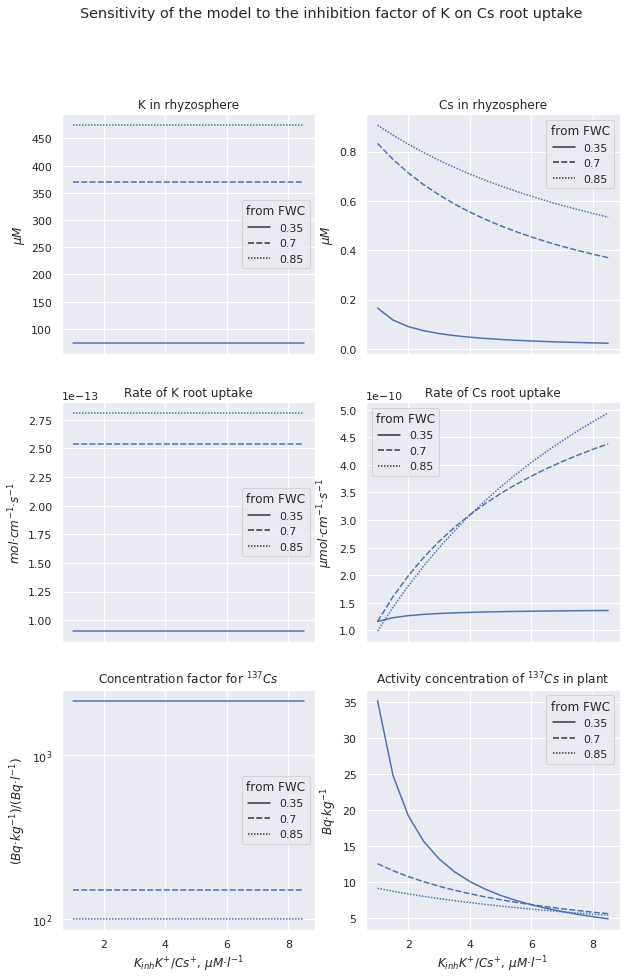

In [31]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_m = 299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85]
calculations2 = {'k_inh': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for k_inh in range(2,18):
    k_inh = k_inh/2
    k_lo = [1]
    cs_lo = [1]
    calculations2['k_inh'].append(k_inh)
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
data_k = pd.DataFrame(calculations2)

impact_variable='k_inh'
impaсt_variable_name = '$K_{inh} K^{+}/Cs^{+}$, $µM·l^{-1}$'
make_graph_sensitivity(impact_variable, impaсt_variable_name, 
                       'Sensitivity of the model to the inhibition factor of K on Cs root uptake')

Увеличение коэффициента ингибирования корневого поглощения Cs^{+} калием увеличивает интенсивность поглощения цезия, что особенно заметно при более высокой подвижности катиона в условиях достаточного увлажнения почвы. В результате концентрация Cs^{+} в ризосфере несколько снижается. Данное снижение более выражено в условиях оптимльной и сверхоптимальной влагообеспеченности. На коэффициент концентрирования ^{137}Cs из почвенного в раствора в надземные части растений это не оказывает никакого влияния. Снижение концентрации всех изотопов Cs в ризофере приводит к умеренному падению удельной активности ^{137}Cs в надземных частях растения при оптимальной и сверхоптимальной влажности почвы. При недостаточной влагообеспеченности снижение удельной активности ^{137}Cs в растении более существенное.


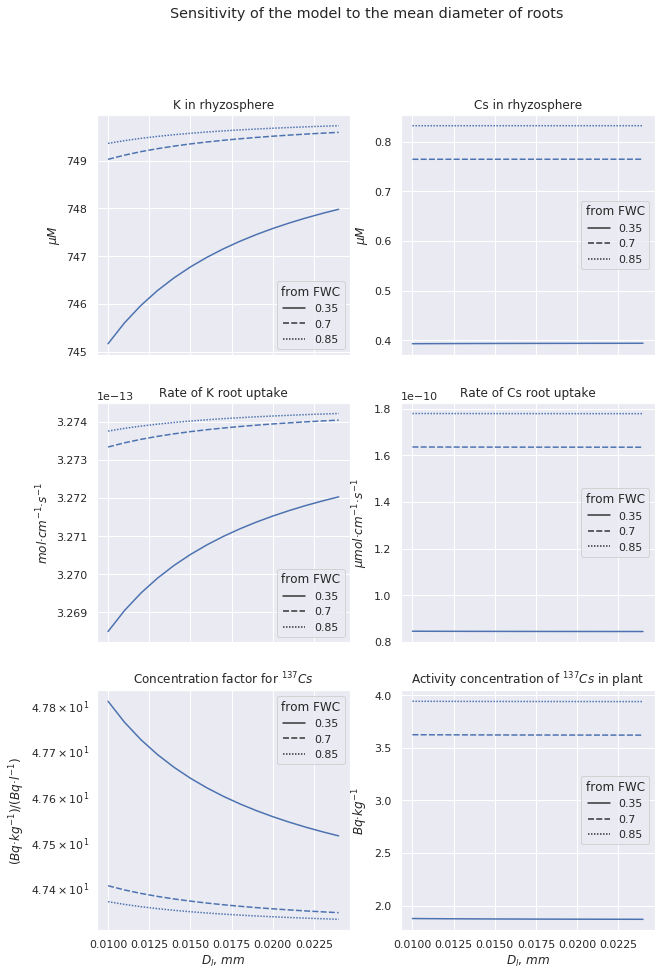

In [34]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_m = 299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85]
calculations2 = {'d_l': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for d_l in range(10, 25):
    d_l = d_l/1000
    k_lo = [1]
    cs_lo = [1]
    calculations2['d_l'].append(d_l)
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
data_k = pd.DataFrame(calculations2)

impact_variable='d_l'
impaсt_variable_name = '$D_{l}$, $mm$'
make_graph_sensitivity(impact_variable, impaсt_variable_name, 
                       'Sensitivity of the model to the mean diameter of roots')

Диаметр всасывающих корней связан с площадью всасывающей поверхности, поэтому, если параметры уравнения Михаэлиса-Ментен приведены в расчете на единицу длины корня, интенсивность поглощения катионов в расчете на единицу площади снижается. В случае K^{+} можно заметить, что увеличение среднего диаметра всасывающих корней повышает концентрацию катиона в ризосфере, что напрямую отражается на интенсивности его корневого поглощения. Однако изменения данных показателей весьма незначительны. Таким образом, значение среднего диаметра всасывающих корней не играет существенной роли в результатах моделирования поведения Cs и K в системе «почва-растение» при различной влажности почвы.


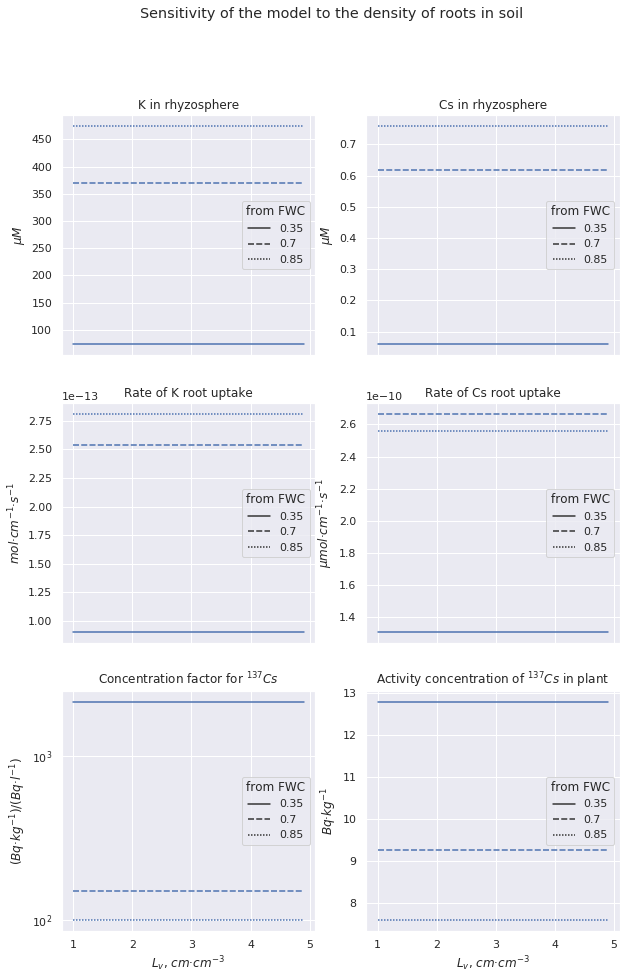

In [33]:
r0 = 1.5e-2
d_l = 1.98e-5
l_v = 3.0
k_m = 299 # 67
c_min = 0
i_max = 4.58e-13 # 52e-14  (моль/л)
c_mean = 750 # mkM
#cs kinetics
i_max_cs = 3e-7 # mkmol/ l 
c_cs = 1 # mkM Cs+ (stable) / common concentration in soil solution 0.1-10 mkM 224e-7 # mkM = 100 Bq/l
cs_solution = 0.1 # Bq/L
sa_cs_solution = cs_solution / c_cs # Bq Cs-137 in 1 mkmol of the cesium isotopes coctail
k_m_cs = 5.8 # mkmol Cs
k_inh = 3.1 # mkmol K
d_lcs = 2.06e-5
nh4_inh = 11.2 # mkmol NH4

theta_rels = [0.35, 0.7, 0.85]
calculations2 = {'l_v': [], 'theta': [], 'theta_rel': [], 'f': [], 'k_lo': [], 'cs_lo': [], 'cf_cs': [], 'cs_plant': [], 'i_k': [], 'i_cs': []}
i=1 # супесчаная почва
for theta_rel in theta_rels:
  theta = soil_gravi['theta_max'][i]*theta_rel
  theta_th = 0.81*soil_gravi['CF'][i] - 0.90*soil_gravi['CF'][i]**2 -  0.07*soil_gravi['SF'][i] - 0.6*soil_gravi['ro'][i] + 0.22*soil_gravi['ro'][i]**2 + 0.42
  f = 1.1 * (theta - theta_th)
  if f < 0.01: continue # plants can't growth in a very dry conditions  # f = 0
  if (theta / soil_gravi['theta_max'][i]) < 0.15: continue # it is also very dry conditions
  for l_v in range(10, 50):
    l_v = l_v/10
    k_lo = [1]
    cs_lo = [1]
    calculations2['l_v'].append(l_v)
    calculations2['theta'].append(theta)
    calculations2['theta_rel'].append(theta_rel)
    calculations2['f'] = f
    ret_k = basinhopping(diff_rhyzo_concentration, k_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    c_k_inh = ret_k.x[0]
    calculations2['k_lo'].append(ret_k.x[0])
    calculations2['i_k'].append(michael_menten(ret_k.x[0], i_max, k_m))
    ret_cs = basinhopping(diff_rhyzo_concentration_cs, cs_lo, minimizer_kwargs=minimizer_kwargs, niter=250)
    cf_cs = cf_cesium(c_k_inh*1e-6) # calculate concentration factor soil_solution to plant
    calculations2['cs_lo'].append(ret_cs.x[0])
    calculations2['i_cs'].append(michael_menten_inhibitory(ret_cs.x[0], i_max_cs, k_m_cs, c_inh=c_k_inh, k_inh=k_inh))
    calculations2['cf_cs'].append(cf_cs)
    sa_cs_plant = cf_cs * (ret_cs.x[0] * sa_cs_solution)
    calculations2['cs_plant'].append(sa_cs_plant)
data_k = pd.DataFrame(calculations2)

impact_variable='l_v'
impaсt_variable_name = '$L_{v}$, $cm·cm^{-3}$'
make_graph_sensitivity(impact_variable, impaсt_variable_name, 
                       'Sensitivity of the model to the density of roots in soil')

Результаты моделирования показали, что изменение плотности всасывающих корней в почве в довольно широких пределах не оказывает существенное влияние на поведение Cs^{+} и K^{+} в почвенном растворе.


Таким образом, кроме собственно средней концентрации катионов K^{+} и Cs^{+} в почвенном растворе на их концентрацию в ризосфере, а следовательно и на биологическую доступность оказывают влияние такие факторы, как механический состав почвы и содержание влаги в почве. Кроме того, на концентрацию K^{+} в ризосфере оказывают существенное влияние такие параметры, как K_{m} и I_{max} уравнения Михаэлиса-Ментен кинетики корневого поглощения K^{+}. На концентрацию Cs^{+} в ризосфере оказывает существенное прямопропорциональное влияние его средняя концентрация в почвенном растворе. Однако при неизменной концентрации радиоактивных изотопов цезия в почве и почвенном растворе на них эта закономерность не распространяется, и на накоплении RCs в органах растений изменения данного параметра практически не отражается. K_{m}, I_{max} для кинетики корневого поглощения K^{+} и Cs^{+}, коэффициент ингибирования поглощения цезия калием оказывают умеренное влияние -- изменения составляют не более 5--10% при варьировании данных показателей в широком диапазоне величин. Влияние данных показателей на накопление RCs в органах растения становится заметнее при недостаточном уровне увлажнения почвы, когда возрастает дефицит K^{+} в ризосфере, что увеличивает коэффициент концентрирования радиоизотопа из почвенного раствора в растение.